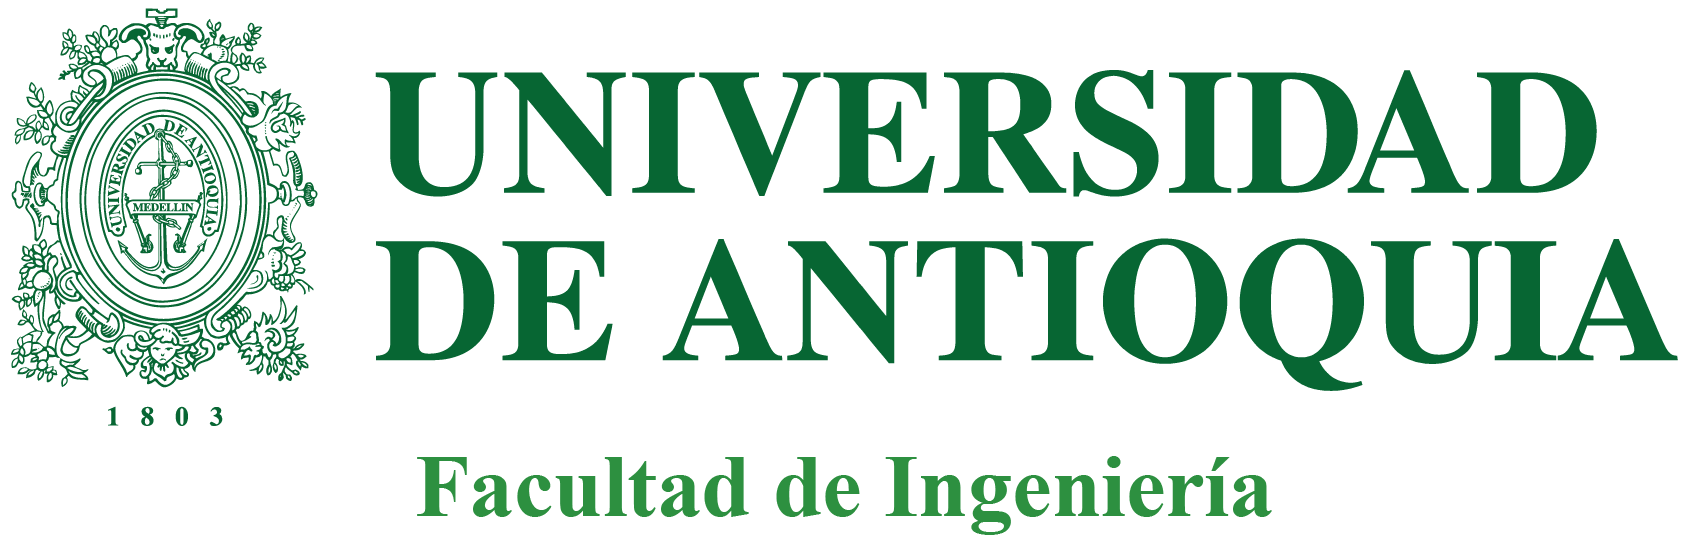
---

**Especialización en Analítica y Ciencia de Datos**

**Universidad de Antioquia**

**2024**

**Melissa Ortega Alzate**

---

<div style="display: flex; align-items: center; justify-content: flex-end; position: fixed; bottom: 10px; right: 10px;">
  <a href="https://colab.research.google.com/github/tu-usuario/tu-repositorio" style="margin-right: 15px;">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" style="height: 25px;">
  </a>
  <a href="https://github.com/melissaortegaa/monografia" style="margin-right: 15px;">
    <img src="https://img.shields.io/badge/GitHub-000?logo=github&logoColor=fff&style=flat" alt="View on GitHub" style="height: 25px;">
  </a>
  <a href="https://www.kaggle.com/code/melissaortegaalzate/04-transfer-learning-ipynb">
    <img src="https://img.shields.io/badge/Kaggle-20BEFF?logo=kaggle&logoColor=fff&style=flat" alt="View on Kaggle" style="height: 25px;">
  </a>
</div>

## Objectives

1. Diseñar y entrenar una red neuronal convolucional CNN utilizando TensorFlow y Keras para clasificar imágenes en dos categorías: Saludables (healthy) o Salmonella.

2. Comparar la arquitectura diseñada cambiando parámetros de compilación de modelo como el optimizador (Adam o RMSprop), la función de pérdida (categorical_crossentropy o binary), la función de activación (sigmoide o softmax), así como la implementación de Dropout y regularizadores (L2).

## Summary

Se diseñaron y compararon ocho modelos de redes neuronales convolucionales (CNN) con el objetivo de examinar cuáles parámetros tienen más influencia o son más efectivos para la tarea especificada:


| Model | Loss | Optimizer | Dropout | Activation Output |
|-------|------|-----------|---------|-------------------|
| 1     | Categorical Crossentropy | Adam (lr = 0.001) | N/A | Sigmoid |
| 2     | Categorical Crossentropy | RMSprop (lr = 0.001) | 0.5 | Sigmoid |
| 3     | Categorical Crossentropy | Adam (lr = 0.001) | 0.5 | Softmax |
| 4     | Categorical Crossentropy | RMSprop (lr = 0.001) | 0.5 | Softmax |
| 5     | Categorical Crossentropy | Adam (lr = 0.001) | N/A | Sigmoid |
| 6     | Categorical Crossentropy | RMSprop (lr = 0.001) | 0.5 | Sigmoid |
| 7     | Categorical Crossentropy | Adam (lr = 0.001) | 0.5 | Softmax |
| 8     | Categorical Crossentropy | RMSprop (lr = 0.001) | 0.5 | Softmax |

# Imports & Settings

### Library import

In [1]:
# Standard library imports
import os
import random
import zipfile
import sys

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('default')

# Data manipulation and processing
import numpy as np
import pandas as pd

# Image visualization
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img

# Deep learning frameworks and utilities
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential

# Callbacks and optimizers
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.optimizers import Adam, RMSprop

# Metrics and evaluation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load the TensorBoard notebook extension
%load_ext tensorboard
import datetime, os

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

# GPU Consiguration
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU.')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU.')
    
# Confirmation
print ('\nThe modules were sucesfully loaded.')

2024-05-26 17:55:09.018485: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-26 17:55:09.018585: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-26 17:55:09.151619: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using GPU.

The modules were sucesfully loaded.


In [2]:
# Google Drive conection
!pip install gdown
import gdown

### Tensorflow configuration

In [3]:
# System configuration
if 'google.colab' in sys.modules:
    print ("setting tensorflow version in colab")
    %tensorflow_version 2.x
tf.__version__

'2.15.0'

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs")
    except RuntimeError as e:
        print(e)


1 Physical GPUs, 1 Logical GPUs


In [5]:
# Reproducibility
np.random.seed(0)
tf.random.set_seed(0)
random.seed(0)

# Load the dataset


In [6]:
# Download the preprocessed zip file from Google Drive
!gdown '1ZYWZY0GsHBKw67mk-0MLLZmow2At7VG0' -O \
    /tmp/data1.zip

Downloading...
From (original): https://drive.google.com/uc?id=1ZYWZY0GsHBKw67mk-0MLLZmow2At7VG0
From (redirected): https://drive.google.com/uc?id=1ZYWZY0GsHBKw67mk-0MLLZmow2At7VG0&confirm=t&uuid=1b007055-12cc-4362-93c9-278d1e8550fe
To: /tmp/data1.zip
100%|█████████████████████████████████████████| 172M/172M [00:01<00:00, 117MB/s]


In [7]:
# Extract the files
local_zip = '/tmp/data1.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/data')
zip_ref.close()

In [8]:
# Define directories
base_dir = '/tmp/data'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Training directories
train_healthy_dir = os.path.join(train_dir, 'healthy')
train_salmo_dir = os.path.join(train_dir, 'salmo')

# Validation directories
validation_healthy_dir = os.path.join(validation_dir, 'healthy')
validation_salmo_dir = os.path.join(validation_dir, 'salmo')

# Test directories
test_healthy_dir = os.path.join(test_dir, 'healthy')
test_salmo_dir = os.path.join(test_dir, 'salmo')

# Lists of files in folders
train_healthy_fnames = os.listdir(train_healthy_dir)
train_salmo_fnames = os.listdir(train_salmo_dir)

test_healthy_fnames = os.listdir(test_healthy_dir)
test_salmo_fnames = os.listdir(test_salmo_dir)

validation_healthy_fnames = os.listdir(validation_healthy_dir)
validation_salmo_fnames = os.listdir(validation_salmo_dir)

In [9]:
# Print images samples
print(f"Train data examples for 1st class: \n{train_healthy_fnames[:10]}")
print(f"\nTrain data examples for 2nd class: \n{train_salmo_fnames[:10]}")

Train data examples for 1st class: 
['healthy.1036.jpg', 'healthy.1514.jpg', 'healthy.2004.jpg', 'pcrhealthy.309.jpg', 'healthy.619.jpg', 'healthy.46.jpg', 'healthy.362.jpg', 'healthy.566.jpg', 'healthy.539.jpg', 'healthy.1274.jpg']

Train data examples for 2nd class: 
['salmo.1882.jpg', 'salmo.943.jpg', 'salmo.676.jpg', 'salmo.1273.jpg', 'salmo.800.jpg', 'salmo.1599.jpg', 'salmo.1287.jpg', 'salmo.2067.jpg', 'salmo.2092.jpg', 'salmo.117.jpg']


## 2. Data preprocessing and augmentation

En esta sección se aplican 3 transormaciones principales a las imágenes de entrenamiento y validación:

1. Resizing: Todas las imágenes se redimensionan a 224x224.

2. Normalization: las imágenes son reescaladas a una razón de 1,/255 para que todos los pixeles estén en una escala común y facilitar el entramiento de los modelos.

3. Augmentation: se añaden rotaciones, cizallamientos, ampliaciones y volteos a los datos de entrenamiento.

In [10]:
# Define parameters
EPOCHS = 50          # Number of epochs to train the model. An epoch is an iteration over the entire x and y data provided
#epochs: 50-100

BATCH_SIZE = 32      # Number of samples per gradient update
#batch size: 32-64

STEPS_PER_EPOCH = 20 # Total number of steps (batches of samples) before declaring one epoch finished and starting the next epoch
#steps: imgs/batch_size
VALIDATION_STEPS = 10

In [11]:
# Transforms will be added to the images to increase the size of the datasets.
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

test_datagen = ImageDataGenerator(rescale=1./255,)
validation_datagen = ImageDataGenerator(rescale=1./255,)

# Flow training images in batches using train_datagen generator for categorical models.
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        color_mode="rgb",
        batch_size = BATCH_SIZE,
        class_mode='categorical',
        seed=42,
        shuffle=False)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        color_mode="rgb",
        batch_size = BATCH_SIZE,
        class_mode='categorical',
        seed=42,
        shuffle=False)

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(224, 224),
        color_mode="rgb",
        batch_size = BATCH_SIZE,
        class_mode='categorical',
        seed=42,
        shuffle=False)

Found 4023 images belonging to 2 classes.
Found 753 images belonging to 2 classes.
Found 253 images belonging to 2 classes.


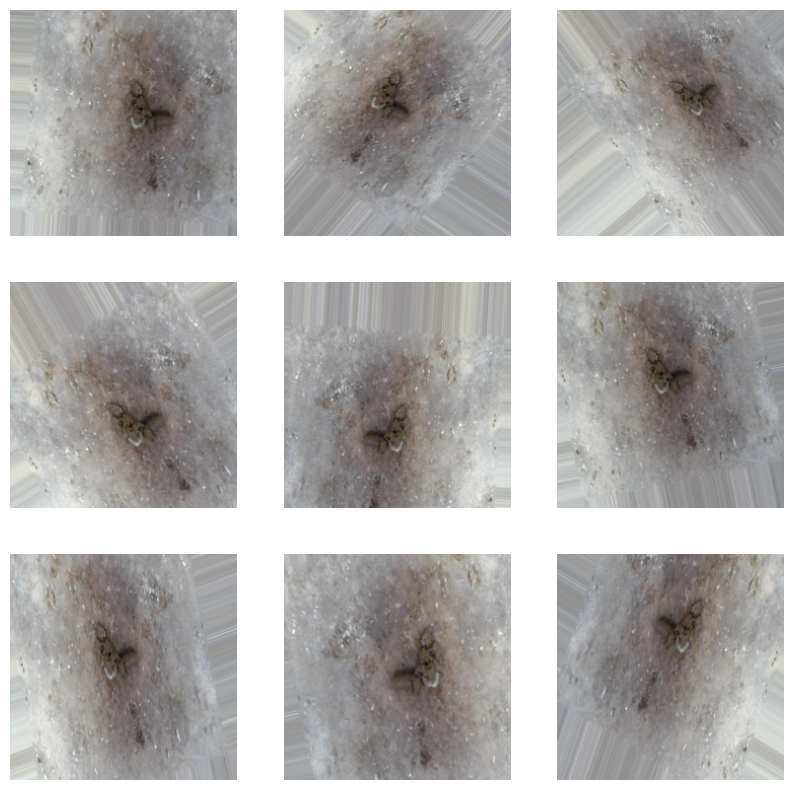

In [12]:
# Visualize image augmentation
img_path = os.path.join(train_healthy_dir, train_healthy_fnames[2])
img = load_img(img_path, target_size=(224, 224))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (224, 224, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 224, 224, 3)

# Define the number of subplots
num_plots = 9

# Create a single figure with subplots
fig, axs = plt.subplots(3, 3, figsize=(10, 10))

# The .flow() command below generates batches of randomly transformed images
# It will loop indefinitely, so it `breaks` the loop at some point
i = 0
for batch in train_datagen.flow(x, batch_size=1):
    axs.flat[i].imshow(array_to_img(batch[0]))
    axs.flat[i].axis('off')
    i += 1
    if i == num_plots:
        break

plt.show()

## 3. CNN architectures

La arquitectura diseñada para los 8 modelos comprende las siguientes capas:

| Layer (type)               | Output Shape              | Param  |
|----------------------------| ---------------------     |--------|
| input_2 (InputLayer)        | (None, 150, 150, 3)   | 0      |        
| conv2d_3 (Conv2D)           | (None, 148, 148, 16)     | 448    |     
| max_pooling2d_3 (MaxPooling2D)  | (None, 74, 74, 16)   | 0 |                                                    
| conv2d_4 (Conv2D)          | (None, 72, 72, 32)   | 4640      
| max_pooling2d_4 (MaxPooling2D)    | (None, 36, 36, 32)  |0 |                                                        
| conv2d_5 (Conv2D)          | (None, 34, 34, 64)   | 18496     
| max_pooling2d_5 (MaxPooling2D) | (None, 17, 17, 64)   | 0  |                                                         
| flatten_1 (Flatten)        | (None, 18496)        | 0         
| dense_2 (Dense)            | (None, 512)          | 9470464   
| dropout_1 (Dropout)        | (None, 512)          | 0         
| dense_3 (Dense)            | (None, 2)            | 1026      

Cada modelo tiene al menos 9,495,074 parámetros para optimizar. Además, todos los modelos, excepto el 1 y el 5 tienen una capa de dropout.

Para compilar los modelos se utilizó el optimizador Adam y RMSprop. En todos los casos, se emplea la precisión (Accuracy) como métrica a comparar:

In [16]:
# Create models
def create_cnn_model(loss, optimizer, dropout, activation_output, use_regularization=False):
    model = Sequential()
    model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())

    # Dynamic architecture
    if use_regularization:
        model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    else:
        model.add(Dense(512, activation='relu'))

    if dropout:
        model.add(Dropout(dropout))

    # Output
    model.add(Dense(2, activation=activation_output))

    # Model compilation
    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy', tf.keras.metrics.Recall()])
    return model

In [17]:
# Define models to evaluate
models_info = [
    ("Model 1", "categorical_crossentropy", tf.keras.optimizers.Adam(learning_rate=0.001),    None, "softmax", True),
    ("Model 2", "categorical_crossentropy", tf.keras.optimizers.Adam(learning_rate=0.001),    0.5,  "softmax", True),
    ("Model 3", "categorical_crossentropy", tf.keras.optimizers.Adam(learning_rate=0.001),    0.5,  "softmax", False),
    ("Model 4", "categorical_crossentropy", tf.keras.optimizers.RMSprop(learning_rate=0.001), None, "softmax", True),
    ("Model 5", "categorical_crossentropy", tf.keras.optimizers.RMSprop(learning_rate=0.001), 0.5,  "softmax", True),
    ("Model 6", "categorical_crossentropy", tf.keras.optimizers.RMSprop(learning_rate=0.001), 0.5,  "softmax", False),
]

In [18]:
# Create, compile and summarize the models
for name, loss, optimizer, dropout, activation_output, use_regularization in models_info:
    model = create_cnn_model(loss, optimizer, dropout, activation_output, use_regularization)

    # Summarize the model
    print(f"\n{name} Summary\n{'--'*20}")
    model.summary()


Model 1 Summary
----------------------------------------


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,536,162 (36.38 MB)

 Trainable params: 9,536,162 (36.38 MB)

 Non-trainable params: 0 (0.00 B)


Model 2 Summary
----------------------------------------


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,536,162 (36.38 MB)

 Trainable params: 9,536,162 (36.38 MB)

 Non-trainable params: 0 (0.00 B)


Model 3 Summary
----------------------------------------


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,536,162 (36.38 MB)

 Trainable params: 9,536,162 (36.38 MB)

 Non-trainable params: 0 (0.00 B)


Model 4 Summary
----------------------------------------


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,536,162 (36.38 MB)

 Trainable params: 9,536,162 (36.38 MB)

 Non-trainable params: 0 (0.00 B)


Model 5 Summary
----------------------------------------


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,536,162 (36.38 MB)

 Trainable params: 9,536,162 (36.38 MB)

 Non-trainable params: 0 (0.00 B)


Model 6 Summary
----------------------------------------


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,536,162 (36.38 MB)

 Trainable params: 9,536,162 (36.38 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# Define the ModelCheckpoint callback to save the best model based on the validation metric
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


## 4. Tensorboard configuration

In [25]:
# Tensorboard configuration
logdir_parent = "logs"

## 5. Training the models

Se evaluó además, la implementación de *early stopping* en cada modelo utilizando una paciencia de 20 épocas:

In [26]:
# Define early stopping parameters
earlystop = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=15, verbose=1, mode='auto', restore_best_weights=True)



In [ ]:
# Train the models
results = []
models = []
training_histories = []

for i, (name, loss, optimizer, dropout, activation_output, use_regularization) in enumerate(models_info):
    # Create and compile the model
    model = create_cnn_model(loss, optimizer, dropout, activation_output, use_regularization)
    models.append(model)

    # Tensorboard callback
    logdir = os.path.join(logdir_parent, name, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = TensorBoard(logdir, histogram_freq=1)

    # Train the model
    print(f"\nModel {i+1}\n{'--'*20}")
    history = model.fit(
        train_generator,
        steps_per_epoch=STEPS_PER_EPOCH,
        epochs=EPOCHS,
        validation_data=test_generator,
        validation_steps=VALIDATION_STEPS,
        verbose=0,
        callbacks=[earlystop, checkpoint],
    )

    # Store the training history
    training_histories.append(history)

    # Display the best accuracy
    history_model = pd.DataFrame(history.history)
    print(f"\nThe best accuracy:")
    history_model_acc = history_model.sort_values(by='accuracy', ascending=False)
    display(history_model_acc.head(1))

    # Display the best validation accuracy
    print(f"\nThe best validation accuracy:")
    history_model_val_acc = history_model.sort_values(by='val_accuracy', ascending=False)
    display(history_model_val_acc.head(1))

    # Display the best validation recall
    #print(f"\nThe best validation recall:")
    #val_recall_column = [col for col in history_model.columns if col.startswith('val_recall')]
    #history_model_val_rec = history_model.sort_values(by=val_recall_column[0], ascending=False)
    #display(history_model_val_rec.head(1))

    # Store the results
    results.append((name, history))


Model 1
----------------------------------------


2024-05-26 18:04:32.435534: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49295: 4.25514, expected 3.61721
2024-05-26 18:04:32.435590: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49296: 5.13285, expected 4.49491
2024-05-26 18:04:32.435600: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49346: 5.29403, expected 4.65609
2024-05-26 18:04:32.435616: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49349: 5.09757, expected 4.45964
2024-05-26 18:04:32.435624: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49350: 5.27288, expected 4.63495
2024-05-26 18:04:32.435632: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49351: 5.07595, expected 4.43801
2024-05-26 18:04:32.435640: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49366: 5.21611, expected 4.57817
2024-05-26 18:04:32.435648:


Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to best_model.keras


2024-05-26 18:04:46.060049: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 11: 4.77941, expected 4.1952
2024-05-26 18:04:46.060105: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12: 4.6448, expected 4.06059
2024-05-26 18:04:46.060115: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 66: 4.62353, expected 4.03933
2024-05-26 18:04:46.060123: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 67: 4.5939, expected 4.00969
2024-05-26 18:04:46.060131: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 83: 4.64646, expected 4.06225
2024-05-26 18:04:46.060139: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 180: 4.49561, expected 3.9114
2024-05-26 18:04:46.060147: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 181: 4.74504, expected 4.16083
2024-05-26 18:04:46.060154: E external/local_xla/x


Epoch 2: val_accuracy did not improve from 1.00000


2024-05-26 18:05:11.469810: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 6.30262, expected 5.56197
2024-05-26 18:05:11.469857: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 5.86678, expected 5.12613
2024-05-26 18:05:11.469872: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 5.88438, expected 5.14374
2024-05-26 18:05:11.469890: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 6.03629, expected 5.29565
2024-05-26 18:05:11.469902: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 6.36172, expected 5.62107
2024-05-26 18:05:11.469913: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 10: 5.75664, expected 5.01599
2024-05-26 18:05:11.469924: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 11: 4.43639, expected 3.69574
2024-05-26 18:05:11.469934: E external/local_xla/xla/


Epoch 3: val_accuracy did not improve from 1.00000

Epoch 4: val_accuracy did not improve from 1.00000


## 6. Evaluation and testing

In [ ]:
%tensorboard --logdir logs

### Performance metrics

In [ ]:
# Visualize validation loss and accuracy for each model
for i, model in enumerate(models):
    print(f"\nModel {i+1}\n{'--'*20}")
    loss, accuracy, recall = model.evaluate(validation_generator)

### Histories plot

In [ ]:
# Get histories for each model
histories = [result[1] for result in results]
titles = [result[0] for result in results]

# Create figure and axes
fig, axes = plt.subplots(len(histories),3, figsize= (13,20))

# Get x-axis lenght
max_epoch = max([max(history.epoch) for history in histories])

# Plot the results for every epoch of each model
for i, history in enumerate(histories):

        hist = pd.DataFrame(history.history)
        hist['epoch'] = history.epoch

        # Plot loss
        axes[i,0].plot(hist['epoch'], hist['loss'], label= 'train', ls ='-', color = 'red')
        axes[i,0].plot(hist['epoch'], hist['val_loss'], label = 'validation',ls ='--', color = 'blue')
        axes[i,0].set_ylabel('Loss')
        axes[i,0].set_title("Loss", fontweight='bold')

        # Plot accuracy
        axes[i,1].plot(hist['epoch'], hist['accuracy'], label= 'train',  ls ='-', color = 'red')
        axes[i,1].plot(hist['epoch'], hist['val_accuracy'], label = 'validation', ls = '--', color = 'blue')
        axes[i,1].set_ylabel('Accuracy')
        axes[i,1].set_title("Accuracy", fontweight='bold')

        # Plot recall
        val_recall_columns = [col for col in hist.columns if 'recall' in col]
        if val_recall_columns:
            axes[i,2].plot(hist['epoch'], hist[val_recall_columns[0]], label= 'train',  ls ='-', color = 'red')
            axes[i,2].plot(hist['epoch'], hist[val_recall_columns[1]], label= 'validation', ls = '--', color = 'blue')
            axes[i,2].set_ylabel('Recall')
            axes[i,2].set_title("Recall", fontweight='bold')
        else:
            print(f"No se encontraron columnas de recall en la historia del modelo {titles[i]}")

        # Styling
        for j in range(3):
            axes[i,j].set_xlabel('Epoch')
            axes[i,j].legend()
            axes[i,j].set_xlim([0, max_epoch+2])
            axes[i,j].set_ylim([0, 1])
            axes[i,j].grid(True)

        plt.subplots_adjust(hspace=0.5)
        plt.figtext(0.5, ((i*-0.25) + 0.4), titles[i], va="center", ha="center", size=12)

fig.suptitle("Models training history", fontsize = 13, weight='bold')
plt.tight_layout()
plt.subplots_adjust(top=0.93, hspace= 0.4)
plt.show();

- Aunque el modelo 4 presentó mejor precisión en validación, tanto en el entrenamiento como en la evaluación del modelo completo, es el que requiere más épocas para alcanzarla. Mientras que el modelo 2 tuvo una precisión cercana con 33 épocas menos. Esto implicaría un menor costo computacional.

- La misma observación sucede con el segundo grupo de modelos (5-8), el modelo 6 muestra superioridad en la precisión del conjunto de validación durante el entrenamiento, pero a su vez, requirió el mayor número de épocas. En este caso, 56 épocas más que el modelo 8, con segunda mejor precisión.

### Confussion matrix

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(8, 8))
plt.tight_layout()
plt.subplots_adjust(top=0.85, hspace=0.4)

threshold = 0.5
x = 0
y = 0

for i, model_matrix in enumerate(models):
    # Calculate y_pred
    y_pred = model_matrix.predict(validation_generator)
    # y_pred: array 2 cols
    y_pred = np.argmax(y_pred, axis=1)

    # Get correct labels
    y_test = validation_generator.labels

    # Confusion matrix plotting
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Healthy', 'Salmonella'])

    # Styling
    disp.plot(cmap=plt.cm.YlGnBu, ax=axes[y, x])
    axes[y, x].set_title(titles[i])
    plt.setp(disp.ax_.get_yticklabels(), rotation=90, ha="center", rotation_mode="anchor", fontsize=10)

    x += 1
    if x >= 2:
        x = 0
        y += 1

fig.suptitle("Confusion matrices", fontsize=13, weight='bold')
plt.show();

Se evidencia una alta cantidad de falsos positivos y falsos negativos. Esto sugiere que es importante considerar otras métricas además del accuracy para elegir el modelo con mejor desempeño, sobretodo, en este caso cuando el conjunto de imágenes se encuentra desbalanceado.

Se recomiendaría emplear métricas como sensibilidad (recall) y especificidad, que proporcionan información detallada sobre el desempeño del modelo en términos de la proporción de verdaderos positivos, falsos positivos, verdaderos negativos y falsos negativos.

## 7. Model tunning

In [ ]:
NEW_EPOCHS = 60

In [ ]:
from keras.models import load_model

# Cargar el mejor modelo guardado
best_model = load_model('best_model.h5')

# Compilar el modelo (si es necesario)
best_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Ajuste fino (fine-tuning)
history_fine_tuning = best_model.fit(
    train_generator,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=NEW_EPOCHS,
    validation_data=validation_generator,
    validation_steps=VALIDATION_STEPS,
    verbose=1
)


## 8. Reporting

### Training

Los parámetros de entramiento EPOCHS = 100, BATCH_SIZE = 32, STEPS_PER_EPOCH = 10 y VALIDATION_STEPS = 50 se mantuvieron constantes durante esta exploración. Se reconoce que influyen sobre el rendimiento y desempeño de los modelos. En todos los casos, se utilizaron 32 imágenes a la vez para actualizar el gradiente y esto 10 veces para cada época, en total se utilizaron 320 imágenes en cada una de las 100 épocas. Es decir, 3200 imágenes (15 % del conjunto de entrenamiento) para entrenar cada modelo.

Los resultados se discuten en la siguiente sección:

### Results and interpretation

Todos los modelos presentaron un *Accuracy* mayor al 87 %, evidenciando una precisión aceptable de las Redes Neuronales Convolucionales diseñadas para este tipo de tareas de clasificación.

En general, los modelos de clasificación que utilizaron la combinación entre una función de pérdida *categorical_crossentropy* y función de activación *softmax* tuvieron un desempeño superior que aquellos que utilizaron *binary_crossentropy* y función de activación *softmax*. Es conclusión, en el contexto de problemas de clasificación multi-clase (si fuera el caso), la combinación de *categorical_crossentropy* y *softmax* tiende a producir mejores resultados.

A continuación, se discuten los resultados por grupos de modelos:

### categorical_crossentropy

Respecto a los modelos que tenían como función de pérdida *categorical_crossentropy*, se encontró, que:


| Model | Loss Function | Optimizer | Dropout | Activation Output | Best Val Epoch | Val Loss | Best Val Acc | loss_model | acc_model |
|-------|---------------|-----------|---------|-------------------|----------------|----------|--------------|--------------|--------------|
| 1     | Categorical Crossentropy | Adam (lr = 0.001) | N/A | Sigmoid | 37 | 0.340737 | 0.875 | 0,3476465046 |0,8682849407|
| 2     | Categorical Crossentropy | Adam (lr = 0.001) | 0.5 | Sigmoid | 56 | 0.32679 | 0.87875 |0,3369446397|0,8718662858|
| 3     | Categorical Crossentropy | Adam (lr = 0.001) | 0.5 | Softmax | 44 | 0.343332 | 0.873125 |0,2974246442|0,8925586939|
| 4     | Categorical Crossentropy | RMSprop (lr = 0.001) | 0.5 | Softmax | 89 | 0.29524 | 0.89625 |0,297424525|0,8925586939|

En general, el mejor modelo en términos de precisión en validación, fue el Modelo 4, que utilizó RMSprop como optimizador, dropout de 0.5 y activación softmax en la capa de salida.

Los modelos 1 y 2 difieren en la implementación de una capa de dropout, resultando el modelo 2 con Dropout en una mejor precisión, esta capa puede ayudar a prevenir el sobreajuste y se recomienda incluirla para esta tarea de clasificación. Entre el modelo 2 y 3, sólo difiere la función de activación de la capa de salida, el modelo 2 muestra una precisión ligeramente superior. En este caso, se podría pensar que la función sigmoide entregaría mejores resultados. Sin embargo, se demoró 12 épocas más que el modelo 3 con la función softmax.

Finalmente, al comparar los modelos 3 y 4, los cuáles difieren en el optimizador, el modelo 4 presenta superioridad, siendo el optimizador RMSprop el de mejor desempeño.

Entonces, para este conjunto de modelos, sería interesante probar la combinación de los siguientes parámetros: RMSprop como optimizador, dropout de 0.5 y activación sigmoide en la capa de salida. Es decir, profundizar en el modelo 2 que necesitó muchas menos épocas que el modelo 4.

### binary_crossentropy

Por su parte, aquellos modelos que tenían como función de pérdida *binary_crossentropy*, se encontró, que:

| Model | Loss Function | Optimizer | Dropout | Activation Output | Best Val Epoch | Val Loss | Best Val Acc | loss_model | acc_model |
|-------|---------------|-----------|---------|-------------------|----------------|----------|--------------|--------------|--------------|
| 5     | Binary        | Adam (lr = 0.001) | N/A | Sigmoid | 44 | 0.36664 | 0.879375 | 0,3281672299 | 0,8794269562|
| 6     | Binary        | Adam (lr = 0.001) | 0.5 | Sigmoid | 87 | 0.322885 | 0.880625 |0,3108491898 | 0,8766414523|
| 7     | Binary        | Adam (lr = 0.001) | 0.5 | Softmax | 57 | 0.33045 | 0.87625 |0,345107615|0,8670911193|
| 8     | Binary        | RMSprop (lr = 0.001) | 0.5 | Softmax | 31 | 0.346238 | 0.88 |0,3451077044|0,8670911193|

Al igual que los 4 primeros modelos, estos muestran un rendimiento competitivo con una precisión alrededor del 88 %. El modelo 6, que utiliza Adam como optimizador, dropout de 0.5 y activación sigmoid en la capa de salida, logró la mejor precisión en validación con un valor de 0.880625, luego de 87 épocas.

El Modelo 5, que no utiliza dropout, obtuvo una precisión ligeramente inferior que el modelo 6, esto confirma que **inculir capas de dropout puede ayudar a mejorar el rendimiento de los modelos**.

Los modelos 7 y 8 utilizaron la función de activación softmax en la capa de salida, que es más adecuada para problemas de clasificación multi-clase. Aunque estos modelos obtuvieron una precisión aceptable, es posible que la elección de esta función de activación, en conjunto con la perdida *binary* no sea la más apropiada para este problema de clasificación, lo que podría explicar su rendimiento ligeramente inferior en comparación con los modelos 5 y 6.

## Conclusions

* El mejor modelo en términos de preción durante la evaluación del conjutno de validación fue el modelo 4.

* Incluir la capa de dropout en la arquitectura de la red neuronal mejoró la generalización del modelo, lo que se refleja en una mayor precisión en la validación para aquellos con esta capa.

* La combinación de la función de activación *softmax* y la función de pérdida *categorical_crossentropy* fue levemente más efectiva al tratar este problema como una clasificación multi-clase. La función de activación *sigmoid* y la función de pérdida *binary_crossentropy* fue levemente más efectiva para tratar el problema como una clasificación binaria.

* El optimizador RMSprop demostró ser efectivo en ambos grupos de modelos, mostrando buen desempeño en términos de precisión en la validación.

**Los parámetros que más influenció el rendimiento de los modelos evaluados, fue añadir la capa de dropout y el optimizador.**

## To do

1. Explorar técnicas de balanceo de datos para mejorar la representación de la clase minoritaria (Healthy). En este caso, se podría disminuir la cantidad de imágenes de *Healthy* y examinar si las métricas mejoran.

2. Para aquellos modelos que tuvieron el mejor desempeño, explorar la influencia de otros hiperparámetros como la tasa de aprendizaje de los optimizadores (lr) y la paciencia en el *earlystopping*. Estos dos parámetros fueron fijados para todos los modelos como 0,001 y 5, respectivamente.

3. Incluir en el análisis la duración del entrenamiento de cada modelo, lo cual permitirá comprender mejor el costo computacional asociado a cada uno y que la elección del modelo final, no corresponda sólamente a las métricas de desempeño, sino también al rendimiento asociado.

## References

* scikit-learn:
https://scikit-learn.org/stable/modules/svm.html

* Seaborn plots:https://ichi.pro/es/como-utilizar-python-seaborn-para-analisis-de-datos-exploratorios-28897898172180

* Confussion matrix
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html

## Clean up

In [ ]:
#import os, signal
#os.kill(os.getpid(), signal.SIGKILL)